# Coresets with DPPs

In [1]:
import numpy as np
# import matplotlib as mpl
import matplotlib.pyplot as plt
# %matplotlib widget
%matplotlib inline
%load_ext autoreload 
%autoreload 2
# some highlight keywords by VSCode: TODO, FIXME, BUG, XXX, HACK, NOTE 
# TODO: refactor OPE sample to make one simple OPE sampler and one OPE+uniform sampler
# TODO: sample example
# TODO: message save figure link

## Inspection

### Data generation

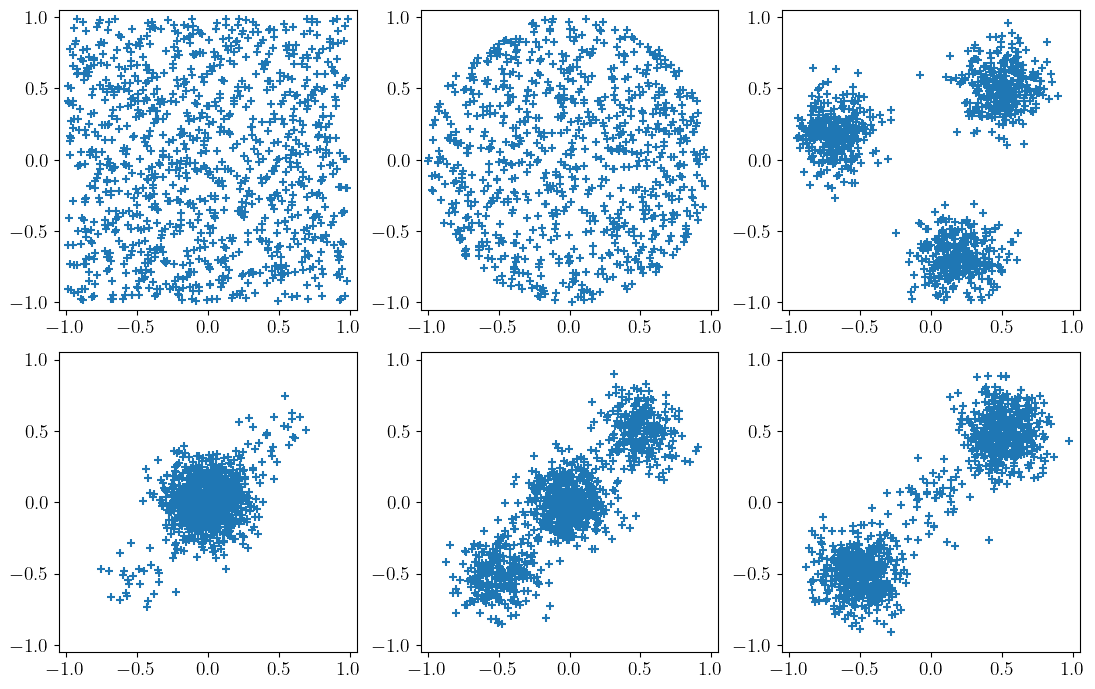

In [50]:
from utils import get_hypercube_data, get_corner_data, get_circle_data, get_disk_data

def draw_data(desired_n, d, k):
    # generate data
    radius_corner = 0.5*2**.5
    X_uniform = get_hypercube_data(desired_n, d, border=.99)
    X_disk = get_disk_data(desired_n, d, radius=1)
    X_corner = get_corner_data(desired_n, d, k, border=.99)
    X_3centers = get_circle_data(desired_n, d, k, radius=radius_corner, variance=1/50, border=.99)
    X1 = get_circle_data(desired_n/2, d, 5, radius=radius_corner, variance=1/50, border=.99)
    X2 = get_circle_data(desired_n/2, d, 1, radius=0, variance=1/50, border=.99)
    X_5subbubbles = np.concatenate((X1, X2))
    X1 = get_circle_data(desired_n*1/100, d, 1, radius=1, variance=1/200, border=.99)
    X2 = get_circle_data(desired_n*99/100, d, 1, radius=0, variance=1/50, border=.99)
    X_outlier = np.concatenate((X1, X2))
    X1 = get_circle_data(desired_n*5/100, d, 2, radius=radius_corner, variance=1/50, border=.99)
    X2 = get_circle_data(desired_n*95/100, d, 1, radius=0, variance=1/50, border=.99)
    X_2vs1_1 = np.concatenate((X1, X2))
    X1 = get_circle_data(desired_n/2, d, 2, radius=radius_corner, variance=1/50, border=.99)
    X2 = get_circle_data(desired_n/2, d, 1, radius=0, variance=1/50, border=.99)
    X_2vs1_2 = np.concatenate((X1, X2))
    X1 = get_circle_data(desired_n*95/100, d, 2, radius=radius_corner, variance=1/50, border=.99)
    X2 = get_circle_data(desired_n*5/100, d, 1, radius=0, variance=1/50, border=.99)
    X_2vs1_3 = np.concatenate((X1, X2))
    # Xs = [X_uniform, X_disk, X_corner, X_3centers, X_5subbubbles, X_outlier, X_2vs1_1, X_2vs1_2, X_2vs1_3]
    Xs = [X_uniform, X_disk, X_3centers, X_2vs1_1, X_2vs1_2, X_2vs1_3]
    return Xs

# plot
desired_n, d, k = 1024, 2, 3
Xs = draw_data(desired_n, d, k)
xylim = 1.05
plt.figure(figsize=(11,7)) # (12,5.5)
for i_plot, X_plot in enumerate(Xs):
    plt.subplot(2,int(np.ceil(len(Xs)/2)),i_plot+1), plt.xlim(-xylim,xylim), plt.ylim(-xylim,xylim)
    plt.scatter(X_plot[:,0], X_plot[:,1], marker="+")
plt.tight_layout(), plt.show();

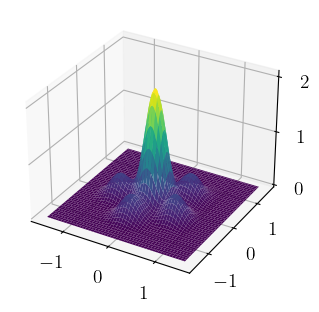

In [141]:
from sklearn.neighbors import KernelDensity
from interfaces import plot3d_func

# compute and plot KDE
kde = KernelDensity(kernel="epanechnikov", bandwidth="scott").fit(Xs[3])
gamma_tilde_pdf = lambda X: np.exp(kde.score_samples(X))
plt.figure(figsize=(8,4))
ax = plt.subplot(121, projection="3d")
plot3d_func(ax, gamma_tilde_pdf, 100)
plt.show();

### Sensitivity

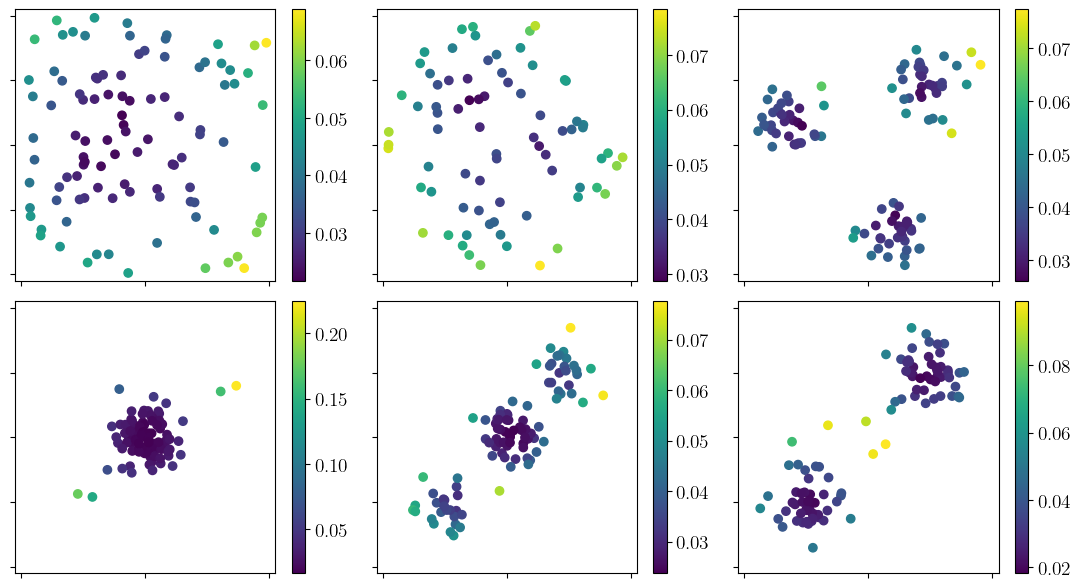

In [51]:
from utils import get_true_sensit

# draw data with less datapoints because of latency 
desired_n, d, k = 100, 2, 3
Xs = draw_data(desired_n, d, k)
# compute and plot sensitivity
plt.figure(figsize=(11,6))
for i_plot, X_plot in enumerate(Xs):
    sensit = get_true_sensit(X_plot, k)
    plt.subplot(2,round(len(Xs)/2),i_plot+1), plt.xlim(-xylim,xylim), plt.ylim(-xylim,xylim)
    plt.scatter(X_plot[:,0], X_plot[:,1], c=sensit), plt.colorbar();
    plt.gca().set_xticklabels([]), plt.gca().set_yticklabels([])    
plt.tight_layout(), plt.show();

### Gaussian k-DPP weights check

empirically yields m=5.000, which should be close to m=5


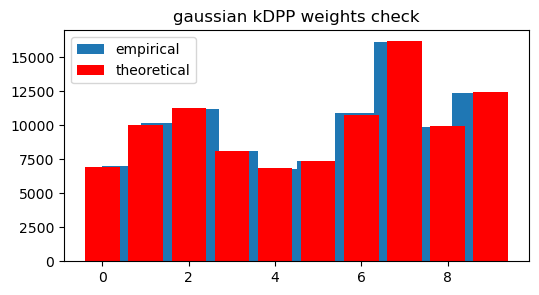

In [5]:
from samplers import gaussian_kernel, get_kDPP_weights, draw_gaussian_kDPP
 
d, n, m, k = 2, 10, 5, 3
X = get_hypercube_data(n, d, border=.99)
n_samples = 20000
bandwidth = 1

likelihood = gaussian_kernel(X, bandwidth)
weights = get_kDPP_weights(likelihood, m)
samples, _ = draw_gaussian_kDPP(X, m, n_samples, bandwidth)
samples = samples.flatten()
print(f"empirically yields m={(1/(n*weights)).sum():.3f}, which should be close to {m=}")
plt.figure(figsize=(6,3))
plt.hist(samples, density=False, label="empirical")
plt.bar(np.arange(len(X)), n_samples/(n*weights), color='r', label="theoretical")
plt.title("gaussian kDPP weights check"), plt.legend();

### Sampling example

obtained n=300
/!\ OPE sampling and gamma_X is None
it will be KDE estimated, inducing n^2 complexity


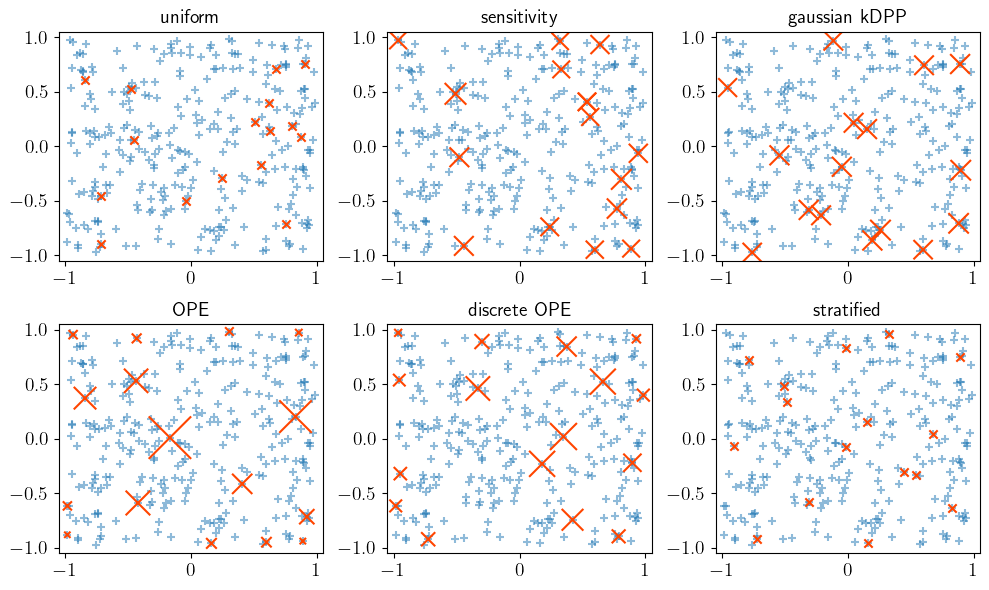

In [27]:
from samplers import draw_uniform, draw_sensitivity, draw_stratified, draw_gaussian_kDPP, draw_OPE, draw_discrete_OPE

# generate data
d, desired_n, m, k = 2, 300, 16, 5
n_samples = 1
radius_corner = 0.5*2**.5
# X1 = get_circle_data(desired_n/2, d, k, radius=radius_corner, variance=1/50, border=.99)
# X2 = get_circle_data(desired_n/2, d, 1, radius=0, variance=1/50, border=.99)
# X = np.concatenate((X1, X2))
X = get_hypercube_data(desired_n, d, border=.99)
n = len(X)
print(f"obtained {n=}")

# sample
samples_weights_list = []
samples_weights_list.append( draw_uniform(X, m, n_samples) )
samples_weights_list.append( draw_sensitivity(X, m, n_samples, k, delta=.1) )
samples_weights_list.append( draw_gaussian_kDPP(X, m, n_samples, bandwidth=.1) )
samples_weights_list.append( draw_OPE(X, m, n_samples, prop_uniform=0) )
samples_weights_list.append( draw_discrete_OPE(X, m, n_samples) )
samples_weights_list.append( draw_stratified(X, m, n_samples) )

# plot
titles = ["uniform","sensitivity","gaussian kDPP","OPE","discrete OPE","stratified"]
plt.figure(figsize=(10,6))
for k, (samples, weights) in enumerate(samples_weights_list):
    X_samples = X[samples]
    xylim = 1.05
    plt.subplot(2,round(len(titles)/2),k+1), plt.xlim(-xylim,xylim), plt.ylim(-xylim,xylim)
    plt.scatter(X[:,0], X[:,1], marker='+', alpha=.5)
    for i_sample in range(n_samples):
        weight = None
        if weights is not None: weight= 200*m*weights[i_sample]
        plt.scatter(X_samples[i_sample,:,0], X_samples[i_sample,:,1], marker="x", s=weight, color="orangered")
    plt.title(titles[k])
    # plt.gca().set_xticklabels([]), plt.gca().set_yticklabels([])
plt.tight_layout(), plt.show();

## Statistics

### Variance and relative error rate

In [53]:
from utils import get_hypercube_data, get_corner_data, get_circle_data
from samplers import draw_uniform, draw_sensitivity, draw_stratified, draw_gaussian_kDPP, draw_OPE, draw_discrete_OPE
from utils import loss, relative_error
from interfaces import save_variables_interface
from sklearn.neighbors import KernelDensity

# data parameters
d, desired_n, k = 2, 1024, 3    # 2, 1024, 3
# draw data
# X = get_hypercube_data(desired_n, d, border=.99)
Xs = draw_data(desired_n, d, k)
X_names = ["X_uniform", "X_disk", "X_3centers", "X_5subbubbles", "X_outlier", "X_2vs1_1", "X_2vs1_2", "X_2vs1_3"]


for X, X_name in zip(Xs, X_names):
    X = Xs[1]
    print(f"experimenting on {X_name} dataset")
    n = len(X)
    print(f"obtained {n=}")

    # repetitions parameters
    n_queries, n_rep = 100, 100 # 50, 500
    ms = np.arange(1,14, dtype=int)**2 # (1,14)
    print(f"m list={ms}")
    # bandwidths = [.01, .03, .05, .1, .3]
    bandwidths = [.01, .05, .10, .20, .30] # .1
    prop_uniforms = np.linspace(0,1,9)[::-1]

    # init queries
    queries = X[np.random.choice(n, (n_queries,k), replace=False)] # np.zeros((1,1,X.shape[-1]))

    # init OPE sampler by pre-computing KDE on data
    kde = KernelDensity(kernel="epanechnikov", bandwidth="scott").fit(X)
    kde_distr = np.exp(kde.score_samples(X))
    # just draw from OPE to test and show in scatter plot
    m = ms[-1]
    OPE_samples, OPE_weights = draw_OPE(X, m, 1, gamma_X=kde_distr, prop_uniform=0)

    SE_means, SE_stds, relerrs = [], [], []
    for m in ms:
        print(f"{m=}")
        # sample
        samples_weights_list = []

        samples_weights_list.append( draw_uniform(X, m, n_rep) )
        samples_weights_list.append( draw_sensitivity(X, m, n_rep, k, delta=.1) )

        # samples_weights_list.append( draw_gaussian_kDPP(X, m, n_rep, bandwidth=.1) )
        # for bandwidth in bandwidths:
        #     samples_weights_list.append( draw_gaussian_kDPP(X, m, n_rep, bandwidth=bandwidth) )

        samples_weights_list.append( draw_OPE(X, m, n_rep, gamma_X=kde_distr, prop_uniform=0) )
        # for prop_uniform in prop_uniforms:
        #     samples_weights_list.append( draw_OPE(X, m, n_rep, gamma_X=kde_distr, prop_uniform=prop_uniform) )
            
        samples_weights_list.append( draw_discrete_OPE(X, m, n_rep) )
        # samples_weights_list.append( draw_stratified(X, m, n_rep) )

        # compute metrics for all samplers
        loss_samples = []
        for samples, weights in samples_weights_list:

            for query in queries:
                # evaluate the population loss and the sample loss
                loss_X = loss(X, query) 
                loss_samples = loss(X, query, samples, weights)

                # compute metrics
                SEs = (loss_samples - loss_X)**2
                SE_means.append(SEs.mean(-1))
                SE_stds.append(SEs.std(-1))
                relerrs.append(relative_error(loss_samples, loss_X))

    # aggregate metrics
    n_ms, n_samplers = len(ms), len(samples_weights_list)
    relerrs_sup = np.reshape(relerrs, (n_ms, n_samplers, n_queries, n_rep)).max(2) # max on queries
    SE_means, SE_stds = np.reshape(SE_means, (n_ms, n_samplers, n_queries)), np.reshape(SE_stds, (n_ms, n_samplers, n_queries))
    SE_means_argmax = SE_means.argmax(2) # argmax on queries
    arr1, arr2 = np.ogrid[:n_ms,:n_samplers]
    SE_means_sup = SE_means[arr1, arr2, SE_means_argmax]
    SE_stds_sup = SE_stds[arr1, arr2, SE_means_argmax]

    save_variables_interface("relerrs_sup, SE_means_sup, SE_stds_sup", 
                        output_name=f"{X_name}_lol_n{n}_m{m}_{k}means{n_queries}_{n_rep}rep", 
                        save_on_call=True)
    raise

experimenting on X_uniform dataset
obtained n=796
m list=[  1   4   9  16  25  36  49  64  81 100 121 144 169]
m=1
m=4
m=9
m=16
m=25
m=36
m=49
m=64
m=81
m=100
m=121
m=144
m=169
Saved variables in ./npys/ folder. To load, type:
```
X_uniform_lol_n796_m169_3means100_100rep = np.load("./npys/X_uniform_lol_n796_m169_3means100_100rep.npy", allow_pickle=True).item()
relerrs_sup, SE_means_sup, SE_stds_sup, = X_uniform_lol_n796_m169_3means100_100rep.values()
```


interactive(children=(Text(value='relerrs_sup, SE_means_sup, SE_stds_sup', description='variable_names'), Text…

RuntimeError: No active exception to reraise

In [102]:
"""ALLSAMPLERS    samples_weights_list.append( draw_uniform(X, m, n_rep) )
    samples_weights_list.append( draw_sensitivity(X, m, n_rep, k, delta=.1) )
    # samples_weights_list.append( draw_gaussian_kDPP(X, m, n_rep, bandwidth=.1) )
    for bandwidth in bandwidths:
        samples_weights_list.append( draw_gaussian_kDPP(X, m, n_rep, bandwidth=bandwidth) )
    # samples_weights_list.append( draw_OPE(X, m, n_rep, gamma_X=kde_distr, prop_uniform=0) )
    for prop_uniform in prop_uniforms:
        samples_weights_list.append( draw_OPE(X, m, n_rep, gamma_X=kde_distr, prop_uniform=prop_uniform) )
    samples_weights_list.append( draw_discrete_OPE(X, m, n_rep) )
    samples_weights_list.append( draw_stratified(X, m, n_rep) )"""

'ALLSAMPLERS    samples_weights_list.append( draw_uniform(X, m, n_rep) )\n    samples_weights_list.append( draw_sensitivity(X, m, n_rep, k, delta=.1) )\n    # samples_weights_list.append( draw_gaussian_kDPP(X, m, n_rep, bandwidth=.1) )\n    for bandwidth in bandwidths:\n        samples_weights_list.append( draw_gaussian_kDPP(X, m, n_rep, bandwidth=bandwidth) )\n    # samples_weights_list.append( draw_OPE(X, m, n_rep, gamma_X=kde_distr, prop_uniform=0) )\n    for prop_uniform in prop_uniforms:\n        samples_weights_list.append( draw_OPE(X, m, n_rep, gamma_X=kde_distr, prop_uniform=prop_uniform) )\n    samples_weights_list.append( draw_discrete_OPE(X, m, n_rep) )\n    samples_weights_list.append( draw_stratified(X, m, n_rep) )'

In [103]:
"""NOSTRAT NOGKDPPLIST    samples_weights_list.append( draw_uniform(X, m, n_rep) )
    samples_weights_list.append( draw_sensitivity(X, m, n_rep, k, delta=.1) )

    samples_weights_list.append( draw_gaussian_kDPP(X, m, n_rep, bandwidth=.1) )
    # for bandwidth in bandwidths:
    #     samples_weights_list.append( draw_gaussian_kDPP(X, m, n_rep, bandwidth=bandwidth) )

    # samples_weights_list.append( draw_OPE(X, m, n_rep, gamma_X=kde_distr, prop_uniform=0) )
    for prop_uniform in prop_uniforms:
        samples_weights_list.append( draw_OPE(X, m, n_rep, gamma_X=kde_distr, prop_uniform=prop_uniform) )
        
    samples_weights_list.append( draw_discrete_OPE(X, m, n_rep) )
    # samples_weights_list.append( draw_stratified(X, m, n_rep) )"""

'NOSTRAT NOGKDPPLIST    samples_weights_list.append( draw_uniform(X, m, n_rep) )\n    samples_weights_list.append( draw_sensitivity(X, m, n_rep, k, delta=.1) )\n\n    samples_weights_list.append( draw_gaussian_kDPP(X, m, n_rep, bandwidth=.1) )\n    # for bandwidth in bandwidths:\n    #     samples_weights_list.append( draw_gaussian_kDPP(X, m, n_rep, bandwidth=bandwidth) )\n\n    # samples_weights_list.append( draw_OPE(X, m, n_rep, gamma_X=kde_distr, prop_uniform=0) )\n    for prop_uniform in prop_uniforms:\n        samples_weights_list.append( draw_OPE(X, m, n_rep, gamma_X=kde_distr, prop_uniform=prop_uniform) )\n        \n    samples_weights_list.append( draw_discrete_OPE(X, m, n_rep) )\n    # samples_weights_list.append( draw_stratified(X, m, n_rep) )'

In [104]:
file_name = "X_uniform_allsamplers_n1024_m169_1means100_100rep"
loading_temp = np.load("./npys/"+file_name+".npy", allow_pickle=True).item()
relerrs_sup, SE_means_sup, SE_stds_sup, = loading_temp.values()

hey


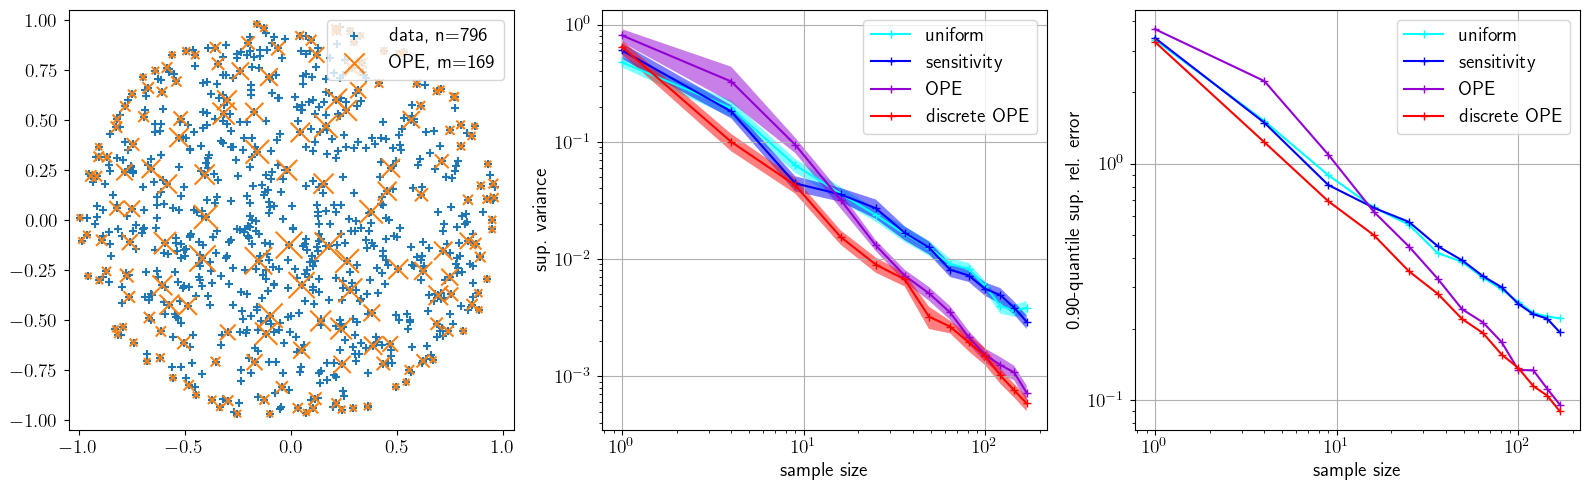

interactive(children=(FloatSlider(value=16.0, continuous_update=False, description='fig_width', max=20.0, min=…

interactive(children=(Text(value='./figs/', description='fig_directory'), Text(value='file_name', description=…

In [60]:
def my_plot():
    n_stds = 1*n_rep**(-.5) # number of standard deviations to plot
    xylim = 1.05

    plt.subplot(131), plt.xlim(-xylim,xylim), plt.ylim(-xylim,xylim)
    plt.scatter(X[:,0], X[:,1], marker="+", label=f"data, {n=}")
    X_samples, X_weights = X[OPE_samples[0]], 100*m*OPE_weights[0]
    plt.scatter(X_samples[:,0],X_samples[:,1], marker="x", label=f"OPE, {m=}", s=X_weights)
    plt.legend()

    plt.subplot(132)
    legends_default = ["uniform","sensitivity","gaussian kDPP"]
    legends_default += [f"prop unif={prop_uniform:.2f}" for prop_uniform in prop_uniforms]
    legends_default +=["OPE","discrete OPE"]
    selector_default_all = [0,1,2,-2,-1]
    selector_default_propunif = [3,7,9,10,11]

    legends_uniform = ["uniform","sensitivity"]
    legends_uniform += [f"gkDPP, h={bandwidth:.2f}" for bandwidth in bandwidths]
    legends_uniform += [f"prop unif={prop_uniform:.2f}" for prop_uniform in prop_uniforms]
    legends_uniform += ["OPE","discrete OPE","stratified"]
    # legends_uniform[4] = "gaussian kDPP"
    selector_uniform_all = [0,1,4,-3,-2,-1]
    selector_uniform_gkdpp = [0,2,3,4,5,6]
    selector_uniform_propunif = [7,11,13,14,15]

    # selector = selector_uniform_all
    # selector = selector_uniform_gkdpp
    selector = selector_uniform_propunif
    # selector = selector_default_all
    # selector = selector_default_propunif
    # legends = np.array(legends_uniform)[selector]
    legends = ["uniform","sensitivity","gaussian kDPP","OPE","discrete OPE","stratified"]
    legends = ["uniform","sensitivity","OPE","discrete OPE"]
    selector = range(len(legends))
    colors = ["cyan","blue","darkviolet","red","orange","maroon"]
    # cmap = plt.get_cmap('viridis') # viridis, magma
    # colors = cmap(np.linspace(0,.9,len(legends)))[::-1]
    plt.gca().set_prop_cycle(color=colors)
    plt.plot(ms, SE_means_sup[:,selector], label=legends, marker="+")
    for k in selector:
        plt.fill_between(ms, SE_means_sup[:,k]+n_stds*SE_stds_sup[:,k], SE_means_sup[:,k]-n_stds*SE_stds_sup[:,k], alpha=.5)
    plt.xscale('log'), plt.yscale('log'), plt.xlabel("sample size"), plt.ylabel("sup. variance"), 
    plt.legend(), plt.grid()

    plt.subplot(133)
    delta_quant = .1 # .1, .01
    relerr_quant = np.quantile(relerrs_sup, 1-delta_quant, axis=-1)
    plt.gca().set_prop_cycle(color=colors)
    plt.plot(ms, relerr_quant[:,selector], label=legends, marker="+")
    plt.xscale('log'), plt.yscale('log'), plt.xlabel("sample size"), plt.ylabel(f"{1-delta_quant:.2f}-quantile sup. rel. error")
    plt.legend(), plt.grid(),

from interfaces import save_plots_interface
save_plots_interface(my_plot, fig_size=(16,5), plot_on_call=True, use_TeX=True, font_size=14, fig_name="file_name")

In [60]:
from ipywidgets import interactive
def lala(truc):
    print(truc)
display(interactive(lala, {"manual":True, "manual_name":"plot figure"},truc="hey"))

interactive(children=(Text(value='hey', description='truc'), Button(description='plot figure', style=ButtonSty…

### Power regression

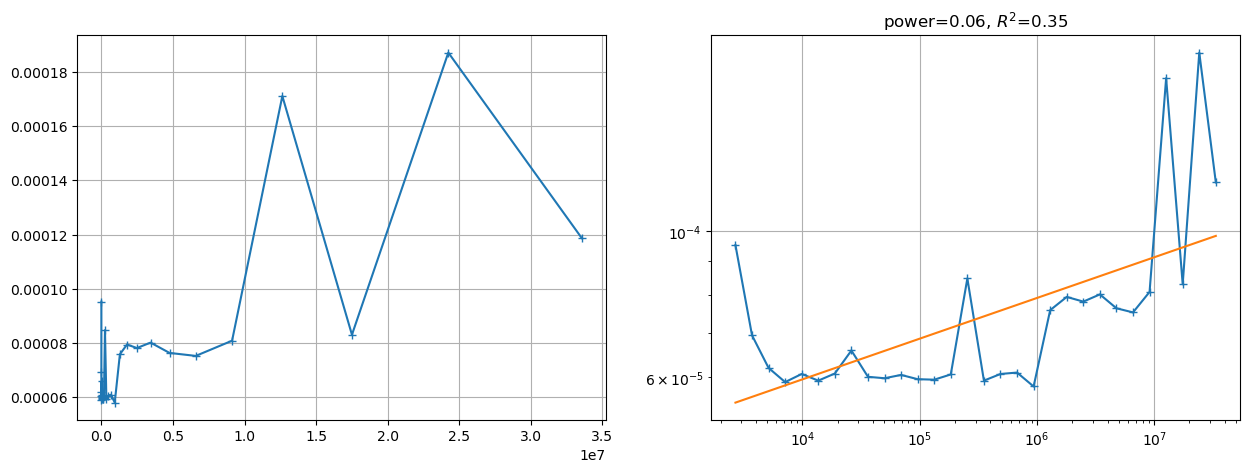

In [27]:
from sklearn.linear_model import LinearRegression

def power_regression(x, y):
    plt.subplot(121)
    plt.plot(x, y, marker="+"), plt.grid()
    logx, logy = np.log(x)[:,None], np.log(y)
    reg = LinearRegression().fit(logx, logy)
    power, factor = reg.coef_, np.exp(reg.intercept_)
    R_squared = reg.score(logx, logy)
    
    plt.subplot(122)
    plt.plot(x, y, marker="+")
    plt.plot(x, np.exp(reg.predict(logx)))
    plt.xscale('log'), plt.yscale('log')
    plt.title(f"power={power[0]:.2f}, $R^2$={R_squared:.2f}"), plt.grid();
    return reg

k_start = 20
plt.figure(figsize=(15,5))
fitted_reg = power_regression(n_list[k_start:], elapsed_times[k_start:])

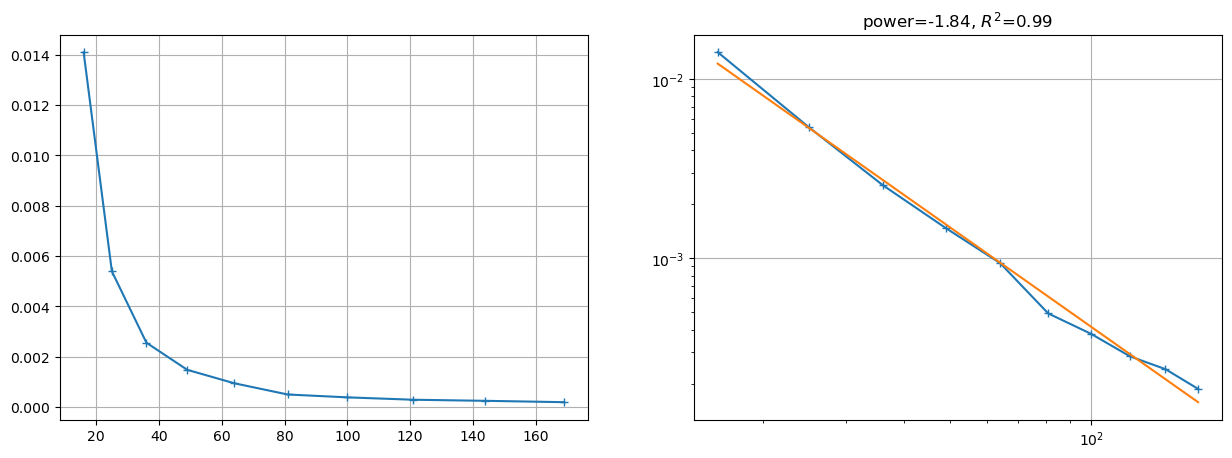

In [44]:
k_start, k_end = 3, None
plt.figure(figsize=(15,5))
fitted_reg = power_regression(ms[k_start:k_end], SE_means[:,2][k_start:k_end])

### Benchmark DPPy sample_exact

In [26]:
from timeit import default_timer as timer
elapsed_times = []
n_list = []
d, n, nb_rep = 2, 2000, 10
ns = np.round(np.logspace(2, 25, num=50, base=2)).astype(int) # 20
# ns = np.arange(1, 30)**4
print(ns)
ab_coeff = 0
ab_coeff_array = np.zeros((d,2)) + ab_coeff
for n in ns:
    print(f"n={n}")
    start_time = timer()
    for rep in range(nb_rep):
        # X = get_hypercube_data(n, d)
        # obtain P which decompose continuous DPP K = PP^T
        # dpp = MultivariateJacobiOPE(m, ab_coeff_array)
        # polynom_X = dpp.eval_multiD_polynomials(X)
        # eig_vals, eig_vecs, weights = draw_OPE(X, int(m), gamma_X=.25)
        # OPE_samples = get_DPP_samples(eig_vals[:m], eig_vecs[:,:m], n_samples=2)
        # gamma_tilde = stats.gaussian_kde(X.T)
        # gamma_X = gamma_tilde.pdf(X.T)
        truc= np.round(n*np.random.rand(nb_rep))
    n_list.append(n)
    elapsed_times.append(timer() - start_time)

[       4        6        8       11       15       20       28       39
       54       75      104      143      198      275      380      527
      729     1010     1398     1935     2680     3710     5136     7111
     9846    13632    18874    26131    36179    50090    69351    96018
   132939   184057   254831   352820   488487   676320   936380  1296439
  1794947  2485144  3440736  4763774  6595549  9131681 12643011 17504524
 24235395 33554432]
n=4
n=6
n=8
n=11
n=15
n=20
n=28
n=39
n=54
n=75
n=104
n=143
n=198
n=275
n=380
n=527
n=729
n=1010
n=1398
n=1935
n=2680
n=3710
n=5136
n=7111
n=9846
n=13632
n=18874
n=26131
n=36179
n=50090
n=69351
n=96018
n=132939
n=184057
n=254831
n=352820
n=488487
n=676320
n=936380
n=1296439
n=1794947
n=2485144
n=3440736
n=4763774
n=6595549
n=9131681
n=12643011
n=17504524
n=24235395
n=33554432


In [25]:
np.random.choice(n, nb_rep), np.random.rand(n, nb_rep).shape

(array([20451574,  6466630, 30246717, 25200919,  1867114, 11104117,
         2257348, 16958323,  4892921, 30294148]),
 (33554432, 10))

# Page formula

$p_{W_{ab}}(\lambda) = $

In [ ]:
n_samples, d = 10, 2
X = np.random.randn(n_samples, d)
W = np.outer()
